# Basics of machine learning with text data: bag-of-words for linear regression



In this tutorial, we'll cover the basics of machine learning with text data by analyzing political tweets.

Using the ubiquitous Python packages `numpy`, `pandas`, `matplotlib`, and `scikit-learn`, we'll train and improve regression models for predicting the number of likes received by a tweet.

To make this a practical example, no computing or pre-processing occurs outside of this notebook: if the correct Python packages are installed, you should be able to run this on your own ([download from GitHub](https://github.com/levon003/ml-visualized/blob/master/_notebook/BoWLinRegTweets.ipynb) and load using [Jupyter](https://jupyter.org/)) or using Google Collab. 

This tutorial covers material in chapters 4-6 of [_Speech and Language Processing_](https://web.stanford.edu/~jurafsky/slp3/) (3rd ed.) by Dan Jurafsky and James H. Martin. For those interested in deeper coverage and more theoretical background, I strongly recommend those chapters.

## Downloading and reading the data

The first step is to download the data: a [collection of US Political Tweets](https://www.reddit.com/r/datasets/comments/6fniik/over_one_million_tweets_collected_from_us/) collected in June 2017 by [Jason Baumgartner](https://twitter.com/jasonbaumgartne).

The `wget` command below should "just work" on Linux or Mac OS (if `wget` is installed). Otherwise, just download the data and run the notebook from wherever you downloaded the data to.






In [2]:
# this should work on Mac (if wget is installed) or Unix
!wget -O - --no-check-certificate https://files.pushshift.io/twitter/US_PoliticalTweets.tar.gz | tar -xz

--2021-10-23 22:52:00--  https://files.pushshift.io/twitter/US_PoliticalTweets.tar.gz
Resolving files.pushshift.io (files.pushshift.io)... 104.21.55.251, 172.67.174.211, 2606:4700:3032::ac43:aed3, ...
Connecting to files.pushshift.io (files.pushshift.io)|104.21.55.251|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 240797053 (230M) [application/octet-stream]
Saving to: ‘STDOUT’

-                   100%[===================>] 229.64M  13.1MB/s    in 18s     

2021-10-23 22:52:18 (13.0 MB/s) - written to stdout [240797053/240797053]



In [1]:
!du -h *.json

1.6G	tweets.json
916K	users.json


In [2]:
# numpy and pandas for data-wrangling
import numpy as np
import pandas as pd
# matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100

In [3]:
import json
with open('users.json', 'r') as infile:
    users = [json.loads(line) for line in infile.readlines()]
user_df = pd.DataFrame(users)
len(user_df)

548

In [4]:
user_df.sort_values(by='followers_count', ascending=False)[['screen_name', 'followers_count']].head(10)

,screen_name,followers_count
150,realDonaldTrump,31712585
147,POTUS,18545354
509,SenSanders,5072538
31,CoryBooker,3094413
118,marcorubio,2554822
520,SenWarren,2412087
501,SenJohnMcCain,2274034
131,NancyPelosi,1126205
90,JerryBrownGov,1119275
515,SenTedCruz,960413


In [5]:
!head -n 1 tweets.json | python -m json.tool

{
    "contributors": null,
    "coordinates": null,
    "created_at": 1217870931,
    "display_text_range": [
        0,
        74
    ],
    "entities": {
        "hashtags": [],
        "symbols": [],
        "urls": [],
        "user_mentions": []
    },
    "favorite_count": 0,
    "favorited": false,
    "geo": null,
    "id": 877418565,
    "id_str": "877418565",
    "in_reply_to_screen_name": null,
    "in_reply_to_status_id": null,
    "in_reply_to_status_id_str": null,
    "in_reply_to_user_id": null,
    "in_reply_to_user_id_str": null,
    "is_quote_status": false,
    "lang": "en",
    "place": null,
    "retweet_count": 0,
    "retweeted": false,
    "screen_name": "JohnBoozman",
    "source": "<a href=\"http://twitter.com\" rel=\"nofollow\">Twitter Web Client</a>",
    "text": "On a conference call about a weekend trip to Iraq to visit Arkansas troops",
    "truncated": false,
    "user_id": 5558312
}


Documentation for keys in the tweet data is provided by Twitter. [See here.](https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet) It looks like we only care about the actual tweet text (`text`), the screen name of the tweeting user (`screen_name`), and the number of likes (`favorite_count`).

In [6]:
with open('tweets.json', 'r') as infile:
    tweets = []
    for line in infile:
        tweet = json.loads(line)
        tweet = {
            'screen_name': tweet['screen_name'],
            'favorite_count': tweet['favorite_count'],
            'retweet_count': tweet['retweet_count'],
            'text': tweet['text'],
        }
        tweets.append(tweet)
tweet_df = pd.DataFrame(tweets)
len(tweet_df)

1243370

In [7]:
counts = tweet_df.screen_name.value_counts()
counts.head(10)

RepDonBeyer        3258
SenatorDurbin      3252
MassGovernor       3250
GovMattBevin       3250
SenTomCotton       3249
SenRonJohnson      3249
GrahamBlog         3249
onetoughnerd       3249
RepScottPeters     3248
GovMalloyOffice    3247
Name: screen_name, dtype: int64

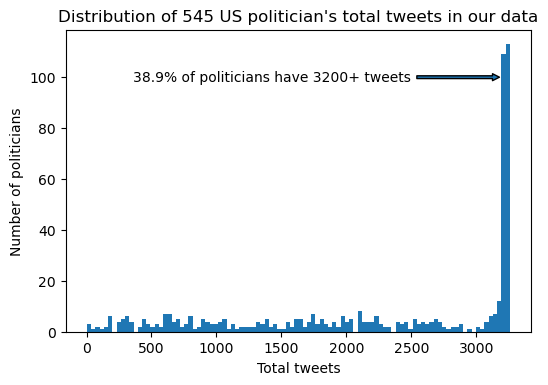

In [8]:
plt.hist(counts, bins=100)
plt.title(f"Distribution of {len(counts)} US politician's total tweets in our data")
plt.xlabel("Total tweets")
plt.ylabel("Number of politicians")
plt.annotate(f'{sum(counts >= 3200) / len(counts):.1%} of politicians have 3200+ tweets', (3200, 100), xytext=(2500, 100), arrowprops={'arrowstyle': 'simple'}, va='center', ha='right')
plt.show()

What's going on here?

The dataset description gives us a clue:

> The tweets are complete up to the oldest date for each user. (In other words, the API allows **going 3,200 back for any particular user**, so the tweets will be complete from present (today) back to oldest date available. If a politician posts frequently (like Trump), it may only go back a year.)

Depending on our particular research question, that restriction may be something we can ignore or it may necessitate changing our data-collection method.

## Machine learning basics: Vectorizing tweets and Training a model

In [9]:
n_train = 100000
n_test = 100000
sampled_tweets = tweet_df.sample(n=n_train + n_test, random_state=0)
len(sampled_tweets)

200000

In [10]:
y = np.array(sampled_tweets.favorite_count, dtype='float32')
y.shape

(200000,)

In [11]:
X = np.array(sampled_tweets.retweet_count, dtype='float32').reshape((-1, 1))
X.shape

(200000, 1)

Let's look at the data matrices we've constructed.

Highest # of likes:
Peaceful protests are a hallmark of our democracy. Even if I don't always agree, I recognize the rights of people to express their views.
Highest # of retweets:
RT @carterjwm: HELP ME PLEASE. A MAN NEEDS HIS NUGGS https://t.co/4SrfHmEMo3


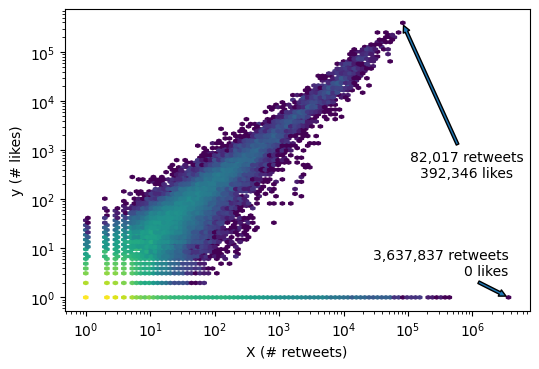

In [12]:
plt.figure()
xs = X.reshape(-1)
ys = y
plt.hexbin(xs + 1, ys + 1, bins='log', xscale='log', yscale='log', mincnt=1)
plt.xlabel("X (# retweets)")
plt.ylabel("y (# likes)")

i = np.argmax(ys)
plt.annotate(f'{int(xs[i]):,} retweets\n{int(ys[i]):,} likes', (xs[i], ys[i]), xytext=(xs[i] * 10, 500), arrowprops={'arrowstyle': 'simple'}, va='center', ha='center')
print("Highest # of likes:")
print(sampled_tweets.iloc[i].text)

i = np.argmax(xs)
plt.annotate(f'{int(xs[i]):,} retweets\n{int(ys[i]):,} likes', (xs[i], 1), xytext=(xs[i], 5), arrowprops={'arrowstyle': 'simple'}, va='center', ha='right')
print("Highest # of retweets:")
print(sampled_tweets.iloc[i].text)

plt.show()

From the figure above, we can notice a few things about our data:
 - Number of retweets and number of likes seem to be positively correlated, as we might expect. If there was no correlation at all, then we would have no hope of modeling the relationship between the two.
 - Looking at the bottom row, there are tweets with many retweets but zero likes, which is surprising. The extreme outlier in the figure above is [this tweet](https://twitter.com/carterjwm/status/849813577770778624), retweeted by a politician in our dataset. If we look at the tweet on twitter, we can see two peculiarities: this tweet has nearly 1 million likes (not 0 as our data suggests) and this tweet has 3.2 million retweets (not 3.6 million as our data suggests).  Clearly, we have an issue with our data.  In a normal analysis, we would need to dig deeper: is this a problem with the API call?  Did the number of retweets decrease since June 2017 organically (due to human users deleting their retweets) or inorganically (due to e.g. Twitter's spam account cleanup operations)?  Note that visualizing the data is what allowed us to find this data error. Always look at your data! For this analysis, we'll move forward with the dataset as-is, accepting that our results will be biased due to this issue.
 - Both number of retweets and number of likes span many orders of magnitude.

In [_Applied Linear Regression_](http://users.stat.umn.edu/~sandy/alr4ed/) (4th ed.) by Sanford Weisberg helpfully includes the **log rule**:

>If the values of a variable range over more than one order of magnitude and the variable is strictly positive, then replacing the variable by its logarithm is likely to be helpful.

Similarly Andrew Gelman exhorts us to ["log transform your positive data"](https://statmodeling.stat.columbia.edu/2019/08/21/you-should-usually-log-transform-your-positive-data/). As our data includes zero counts, we'll use the $\log(x+1)$ transformation instead. (For more graceful alternatives to adding 1, see some discussion [here](https://marcfbellemare.com/wordpress/12856).)

We'll transform both our predictor variable (number of retweets) and our outcome variable (number of likes).

In [13]:
# our data spans multiple orders of magnitude: we'll apply a log transformation
X = np.log(X + 1)
y = np.log(y + 1)

In [14]:
X_train = X[:n_train]
X_test = X[n_train:]
X_train.shape, X_test.shape

((100000, 1), (100000, 1))

In [15]:
y_train = y[:n_train]
y_test = y[n_train:]
y_train.shape, y_test.shape

((100000,), (100000,))

In [16]:
def train_model(X_train, y_train):
    import sklearn.linear_model
    model = sklearn.linear_model.LinearRegression()
    model.fit(X_train, y_train)
    return model

In [17]:
model = train_model(X_train, y_train)

In [18]:
intercept = model.intercept_
slope = model.coef_[0]
intercept, slope

(0.36170352, 0.5771629)

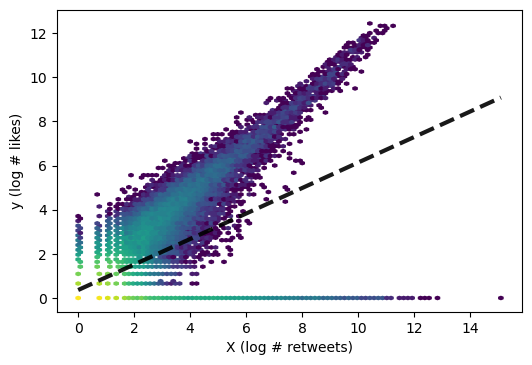

In [19]:
xs = X_test.reshape(-1)
ys = y_test
plt.hexbin(xs, ys, bins='log', mincnt=1)
plt.xlabel("X (log # retweets)")
plt.ylabel("y (log # likes)")

xs.sort()
fit_ys = intercept + slope * xs
plt.plot(xs, fit_ys, '--', linewidth=3, color='black', alpha=0.9)

plt.show()

In [20]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    absolute_errors = np.abs(y_test - y_pred)
    mean_squared_error = np.mean(absolute_errors ** 2)
    return mean_squared_error, absolute_errors, y_pred

mean_squared_error, absolute_errors, y_pred = evaluate_model(model, X_test, y_test)
mean_squared_error

3.7528915

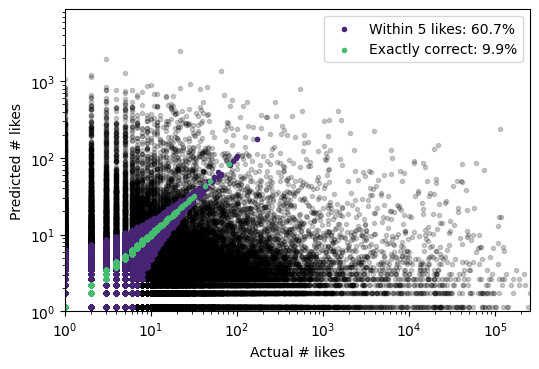

In [21]:
y_pred_actual = np.exp(y_pred) - 1
y_test_actual = np.exp(y_test) - 1

plt.scatter(y_test_actual, y_pred_actual, color='black', marker='.', alpha=0.2)
plt.xlabel("Actual # likes")
plt.ylabel("Predicted # likes")

absolute_errors = np.abs(y_test_actual - y_pred_actual)
correct_inds = absolute_errors <= 5.5
plt.scatter(y_test_actual[correct_inds], y_pred_actual[correct_inds], color=matplotlib.cm.viridis(0.1), marker='.', label=f'Within 5 likes: {np.sum(correct_inds) / len(correct_inds):.1%}')

correct_inds = absolute_errors <= 0.5
plt.scatter(y_test_actual[correct_inds], y_pred_actual[correct_inds], color=matplotlib.cm.viridis(0.7), marker='.', label=f'Exactly correct: {np.sum(correct_inds) / len(correct_inds):.1%}')

plt.legend()

# due to weird axes, we need to tell matplotlib to rescale axes into log
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlim(1, np.max(y_test_actual))
plt.ylim(1, np.max(y_pred_actual))

plt.show()

## Tokenizing texts

To turn texts into vectors, we first split our text into smaller units.

In [22]:
def simple_tokenize(tweet_text):
    tokens = tweet_text.split()
    return tokens
    
tweet_df['tokens'] = tweet_df.text.map(simple_tokenize)

In [23]:
tweet_df['token_count'] = tweet_df.tokens.map(len)
tweet_df.token_count.max()

42

In [24]:
tweet_df[tweet_df.token_count == tweet_df.token_count.max()].text.iloc[0]

'.@SciCmteDems @MichaelEMann @RepBonamici @capitalweather @HouseScience @BadAstronomer @NaomiOreskes @ClimateFdbk @VariabilityBlog @RasmusBenestad @TimOsbornClim @AGW_Prof @CubaRaglanGuy @DeformedEarth @epispheric @mzelinka @hausfath @ChrisJMerchant @LovejoyShaun @PeterGleick And I want to invite anyone who wants to help defend science to fact-check future @HouseScience hearings at the hashtag #FactCheckSST 13/13'

Maybe we should reconsider our tokenization strategy.  

Right now, we treat 'country.'/'country', '#Thanksgiving'/'Thanksgiving', or 'Great'/'great' as different tokens. This is an important modeling decision!

In [25]:
import re

def normalize_token(token):
    # Lowercase and remove all non-alphanumeric characters
    return re.sub("[^0-9a-zA-Z]+", "", token).lower()

def better_tokenize(tweet_text):
    tokens = tweet_text.split()
    tokens_to_keep = []
    for token in tokens:
        if token.startswith('@'):  # replace all @s with a single token
            token = '@'
        elif token.startswith('https://'):  # replace all links with a single token
            token = '/link'
        else:
            token = normalize_token(token)
            if token == '':
                continue
        tokens_to_keep.append(token)
    return tokens_to_keep
    
tweet_df['tokens'] = tweet_df.text.map(better_tokenize)
tweet_df['token_count'] = tweet_df.tokens.map(len)
tweet_df.token_count.max()

42

Here are the longest tweets with the new tokenization strategy.

In [26]:
# here are the longest tweets with the
for row in tweet_df.sort_values(by='token_count', ascending=False).head(5).itertuples():
    print(f"{row.screen_name} ({row.token_count} tokens):\n{row.text}\n{row.tokens}\n")

RepDonBeyer (42 tokens):
.@SciCmteDems @MichaelEMann @RepBonamici @capitalweather @HouseScience @BadAstronomer @NaomiOreskes @ClimateFdbk @VariabilityBlog @RasmusBenestad @TimOsbornClim @AGW_Prof @CubaRaglanGuy @DeformedEarth @epispheric @mzelinka @hausfath @ChrisJMerchant @LovejoyShaun @PeterGleick And I want to invite anyone who wants to help defend science to fact-check future @HouseScience hearings at the hashtag #FactCheckSST 13/13
['scicmtedems', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', 'and', 'i', 'want', 'to', 'invite', 'anyone', 'who', 'wants', 'to', 'help', 'defend', 'science', 'to', 'factcheck', 'future', '@', 'hearings', 'at', 'the', 'hashtag', 'factchecksst', '1313']

GovernorTomWolf (38 tokens):
.@RepLouBarletta @CongBoyle @RepBrady @RepCartwright @RepRyanCostello @RepCharlieDent @USRepMikeDoyle @RepDwightEvans @RepFitzpatrick @MikeKellyPA @RepTomMarino @RepMeehan @RepTimMurphy @RepScottPerry @KeithRothfus @RepBillShus

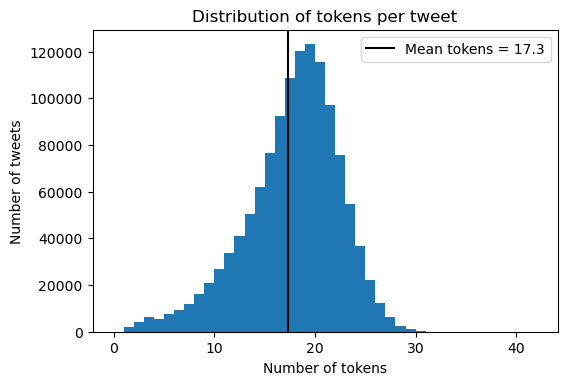

In [27]:
plt.hist(tweet_df.token_count, bins=range(0, tweet_df.token_count.max() + 1))
plt.title("Distribution of tokens per tweet")
plt.xlabel("Number of tokens")
plt.ylabel("Number of tweets")
mean_token_count = tweet_df.token_count.mean()
plt.axvline(mean_token_count, color='black', label=f'Mean tokens = {mean_token_count:.1f}')
plt.legend()
plt.show()

In [28]:
from collections import Counter

token_counter = Counter()
for tokens in tweet_df.tokens:
    token_counter.update(tokens)
token_counter.most_common(10)

[('@', 989015),
 ('to', 779941),
 ('the', 735312),
 ('/link', 499420),
 ('of', 367153),
 ('in', 364656),
 ('for', 338542),
 ('a', 279474),
 ('rt', 267394),
 ('on', 266927)]

## Creating vectors from tokens

 - Choose a set of words (called a "vocabulary").
 - Create a feature for each word in the vocabulary: 0 if the word is present in the text, 1 otherwise.

In [29]:
n_train = 100000
n_test = 100000
sampled_tweets = tweet_df.sample(n=n_train + n_test, random_state=0)

y = np.array(sampled_tweets.favorite_count, dtype='float32')
y = np.log(y + 1)
y.shape

(200000,)

In [30]:
vocabulary = ['/link', 'thanks', 'happy', 'angry', 'the']
V = len(vocabulary)
X = np.zeros((len(sampled_tweets), V), dtype='float32')

for i, tokens in enumerate(sampled_tweets.tokens):
    for j, vocab_token in enumerate(vocabulary):
        if vocab_token in tokens:
            X[i, j] = 1
X.shape

(200000, 5)

In [31]:
# same as above
X_train = X[:n_train]
X_test = X[n_train:]
y_train = y[:n_train]
y_test = y[n_train:]

In [32]:
model = train_model(X_train, y_train)

In [33]:
mean_squared_error, absolute_errors, y_pred = evaluate_model(model, X_test, y_test)
mean_squared_error

2.6667957

### Model comparison

2.67 Mean Squared Error is lower than the 3.75 Mean Squared Error we achieved above, so this content-based model is "better".

Looking at the figure below, we can see that this model predicts far fewer likes on average; when we're wrong, we tend to way _underestimate_ the true number of likes.

Note also that are ability to predict exactly correctly has fallen, from 10% to 6%! That's one sign that Mean Squared Error may be an inappropriate metric for our problem.

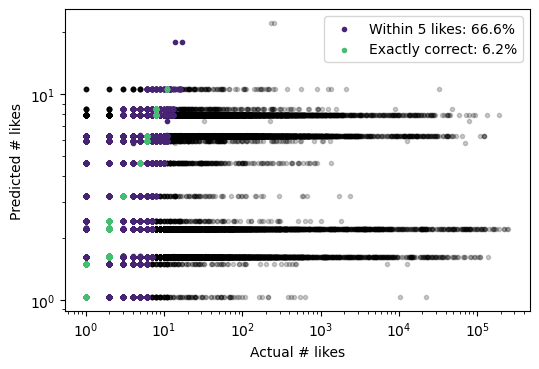

In [34]:
# same visualization as above
y_pred_actual = np.exp(y_pred) - 1
y_test_actual = np.exp(y_test) - 1

plt.scatter(y_test_actual, y_pred_actual, color='black', marker='.', alpha=0.2)
plt.xlabel("Actual # likes")
plt.ylabel("Predicted # likes")

absolute_errors = np.abs(y_test_actual - y_pred_actual)
correct_inds = absolute_errors <= 5.5
plt.scatter(y_test_actual[correct_inds], y_pred_actual[correct_inds], color=matplotlib.cm.viridis(0.1), marker='.', label=f'Within 5 likes: {np.sum(correct_inds) / len(correct_inds):.1%}')

correct_inds = absolute_errors <= 0.5
plt.scatter(y_test_actual[correct_inds], y_pred_actual[correct_inds], color=matplotlib.cm.viridis(0.7), marker='.', label=f'Exactly correct: {np.sum(correct_inds) / len(correct_inds):.1%}')

plt.legend()

# use log scales for the axes
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

plt.show()

### Inspecting the model's weights

Let's create a histogram of model weights.

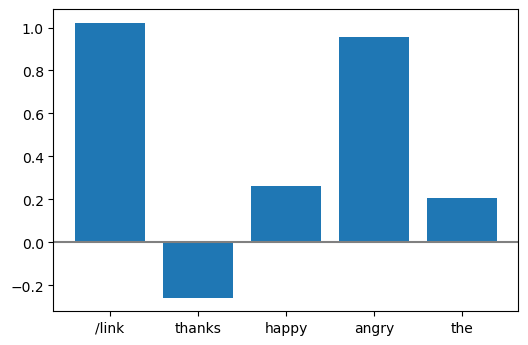

In [35]:
plt.bar(range(V), model.coef_)
plt.axhline(0, color='gray')
plt.xticks(range(V), vocabulary)

plt.show()

We can use these weights as a rough estimate of importance: The presence of links or the word 'angry' are associated with the greatest increase in number of likes. Surprisingly, the presence of the word 'thanks' is associated with a decrease in number of likes. However, interpreting these weights directly is risky: we are likely to have [multi-colinearity](https://en.wikipedia.org/wiki/Multicollinearity) problems.

## Turning tokens into bag-of-words

We don't want to manually choose words for our vocabulary.
 - It's slow and requires lots of domain knowledge.
 - Humans have very bad intuitions about what words are important.
 - Even if we generate a big word list (1000+), we are ignoring most of the content in the tweets!
 
By knowing a little bit about language data, we can choose words in a more general way.

### Zipf's Law

Word (or token) usage follows a predictable distribution.

If 'to' is the most common word and appears at frequency $f_{\text{max}}$, then the frequency of the second most common word is approximately $f = \frac{1}{2} f_{\text{max}}$, the frequency of the third most common word is approximately $f = \frac{1}{3} f_{\text{max}}$, etc.

In general terms, the $k$th most common word appears with frequency $f = \frac{1}{k} f_{\text{max}}$.

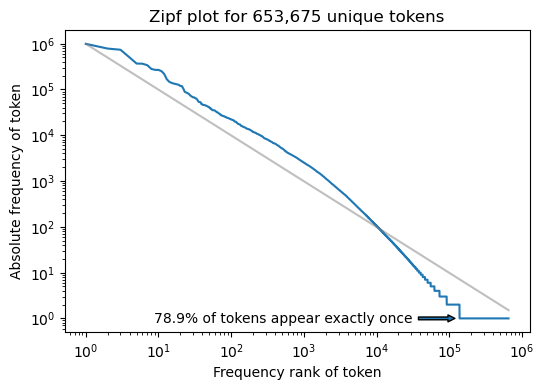

In [36]:
# plot word rank vs word count
token_counts = np.array([count for token, count in token_counter.most_common()])
plt.loglog(range(1, len(token_counts)+1), token_counts)

# compute and plot the counts if the true distribution was Zipfian
largest_count = token_counts[0]
true_zipf = [(1, largest_count)]
for i in np.geomspace(1, len(token_counts), endpoint=True, num=25):
    rank = int(i) + 1
    true_zipf.append((rank, largest_count * 1/rank))
xs, ys = zip(*true_zipf)
plt.plot(xs, ys, color='gray', linestyle='-', alpha=0.5)
plt.xlabel("Frequency rank of token")
plt.ylabel("Absolute frequency of token")
plt.title(f"Zipf plot for {len(token_counts):,} unique tokens")
# annotate the hapax legomena 
plt.annotate(f"{sum(token_counts == 1) / len(token_counts):.1%} of tokens appear exactly once",
             xy=(len(token_counts) * 0.2, 1), xytext=(10**4.5, 1), arrowprops={'arrowstyle': 'simple'}, va='center', ha='right')
plt.show()

We call tokens that appear exactly once [_hapax legomena_](https://en.wikipedia.org/wiki/Hapax_legomenon) or sometimes just _hapaxes_.

80% is higher than we would expect for more general English text. 

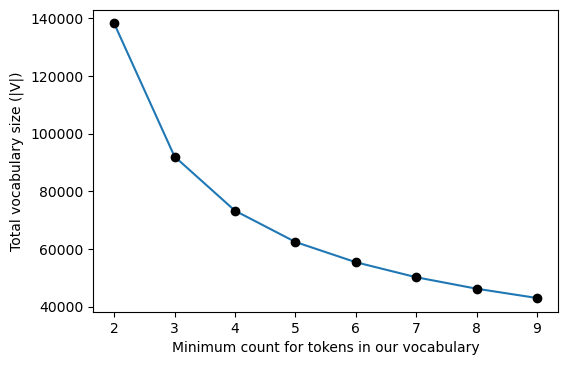

In [37]:
# how large will our vocabulary be at different absolute token frequency cut-offs?
xs = []
ys =[]
for i in range(2, 10):
    xs.append(i)
    ys.append(np.sum(token_counts >= i))
    
plt.plot(xs, ys)
plt.scatter(xs, ys, color='black', zorder=5)
plt.xlabel("Minimum count for tokens in our vocabulary")
plt.ylabel("Total vocabulary size (|V|)")

plt.show()

Note: vocabulary size is an empirical question, and should be chosen based on desired purpose. If the goal is to maximize predictive model performance, than vocab size should be treated as a hyperparameter during model selection.

We'll set our vocab size to 30,000, which is a reasonable and fairly common value.

In [38]:
V = 30000
token_index_map = {}
index = 0
for token, count in token_counter.most_common(V):
    token_index_map[token] = index
    index += 1

In [39]:
# to check our work, we need to map back from indices to the actual token text
index_token_map = {index: token for token, index in token_index_map.items()}

In [40]:
token_index_map['iraq']

1437

In [41]:
index_token_map[1437]

'iraq'

In [42]:
# the very last word in our vocabulary
index_token_map[29999]

'demos'

### Vectorizing texts using our vocabulary
Building the [document-term matrix](https://en.wikipedia.org/wiki/Document-term_matrix). ("Term" just means "token".)

In [43]:
n_train = 100000
n_test = 100000
sampled_tweets = tweet_df.sample(n=n_train + n_test, random_state=0)

y = np.array(sampled_tweets.favorite_count, dtype='float32')
y = np.log(y + 1)
y.shape

(200000,)

In [44]:
X = np.zeros((len(sampled_tweets), V), dtype='float32')
for row_ind, tokens in enumerate(sampled_tweets.tokens):
    for token in tokens:
        if token not in token_index_map:
            # this is a word not in the vocabulary!
            continue
        column_ind = token_index_map[token]
        X[row_ind, column_ind] += 1
X.shape

(200000, 30000)

In [45]:
row_ind = 0
print(sampled_tweets.iloc[row_ind].text + "\n")

for column_ind in np.argwhere(X[row_ind,:]).ravel():
    if column_ind == V:
        print(f"ind= {column_ind:>5}  n= {X[row_ind,column_ind]:.0f}  intercept")
    else:
        token = index_token_map[column_ind]
        print(f"ind= {column_ind:>5}  n= {X[row_ind,column_ind]:.0f}  token= {token}")


ICYMI I called on my colleagues in Congress to reform how we calculate Social Security COLAs https://t.co/JOPaHggJe2

ind=     1  n= 1  token= to
ind=     3  n= 1  token= /link
ind=     5  n= 1  token= in
ind=     9  n= 1  token= on
ind=    16  n= 1  token= i
ind=    17  n= 1  token= my
ind=    19  n= 1  token= we
ind=    61  n= 1  token= congress
ind=    79  n= 1  token= how
ind=   172  n= 1  token= security
ind=   174  n= 1  token= icymi
ind=   189  n= 1  token= reform
ind=   333  n= 1  token= colleagues
ind=   721  n= 1  token= social
ind=   921  n= 1  token= called
ind= 25594  n= 1  token= calculate
ind= 26036  n= 1  token= colas


### Sidebar: using sparse matrices to save memory

As we can see from the code below, the dense matrix we've instantiated uses almost 22GB of RAM. Further, 99.9% of the cells in the matrix are zero, which is a huge waste of memory.

In [48]:
X.nbytes / 1024 / 1024 / 1024  # 22 GB!!!

22.351741790771484

In [49]:
# 99.9% of cells in our matrix are zero!! huge waste of memory
np.sum(X == 0) / (X.shape[0] * X.shape[1])

0.999485602

In practice, we'll use a _sparse matrix_ format to only store the cells that contain non-zero values.

We can use the [`scipy.sparse`](https://docs.scipy.org/doc/scipy/reference/sparse.html) package for this.  In our case, we can convert directly from the dense format to the sparse matrix format, but we can save memory by constructing the matrix directly in the sparse format.

In [51]:
import scipy.sparse
X = scipy.sparse.coo_matrix(X)

In [59]:
# NNZ = "Number of Non-Zero" values stored in the matrix
n_stored_bytes = (X.nnz * 4)
n_stored_bytes / 1024 / 1024 / 1024  # 0.01 GB!

0.01149769127368927

In [61]:
X = X.tocsr()

In [67]:
import sklearn.preprocessing
X = sklearn.preprocessing.StandardScaler(with_mean=False).fit_transform(X)
X.shape

(200000, 30000)

### Training a model using the document-term matrix

In [62]:
# same as above
X_train = X[:n_train]
X_test = X[n_train:]
y_train = y[:n_train]
y_test = y[n_train:]
X_train.shape, X_test.shape

((100000, 30000), (100000, 30000))

Previously, we've trained models using our convenience function: `model = train_model(X_train, y_train)`

This will take an absurdly large amount of resources with our current feature matrix!  For numerical reasons, we can speed up optimization by using [ElasticNet regularization](https://en.wikipedia.org/wiki/Elastic_net_regularization).  Note that this has a side-effect of encouraging the model to set individual feature weights to zero.

In [ ]:
import sklearn.linear_model
model = sklearn.linear_model.ElasticNet(alpha=0.1, l1_ratio=0.01)
model.fit(X_train, y_train)

In [65]:
mean_squared_error, absolute_errors, y_pred = evaluate_model(model, X_test, y_test)
mean_squared_error

2.1918552

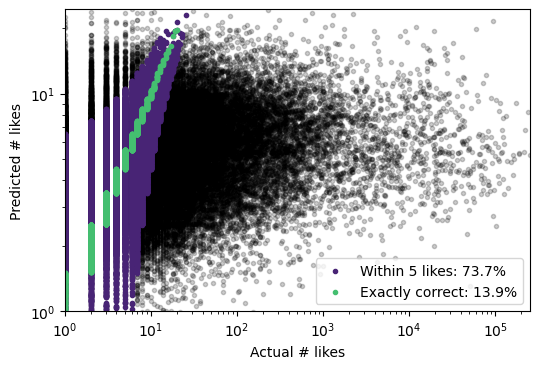

In [51]:
# same visualization as above
y_pred_actual = np.exp(y_pred) - 1
y_test_actual = np.exp(y_test) - 1

plt.scatter(y_test_actual, y_pred_actual, color='black', marker='.', alpha=0.2)
plt.xlabel("Actual # likes")
plt.ylabel("Predicted # likes")

absolute_errors = np.abs(y_test_actual - y_pred_actual)
correct_inds = absolute_errors <= 5.5
plt.scatter(y_test_actual[correct_inds], y_pred_actual[correct_inds], color=matplotlib.cm.viridis(0.1), marker='.', label=f'Within 5 likes: {np.sum(correct_inds) / len(correct_inds):.1%}')

correct_inds = absolute_errors <= 0.5
plt.scatter(y_test_actual[correct_inds], y_pred_actual[correct_inds], color=matplotlib.cm.viridis(0.7), marker='.', label=f'Exactly correct: {np.sum(correct_inds) / len(correct_inds):.1%}')

plt.legend()

# use log scales for the axes
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlim(1, np.max(y_test_actual))
plt.ylim(1, np.quantile(y_pred_actual, 0.9999))

plt.show()

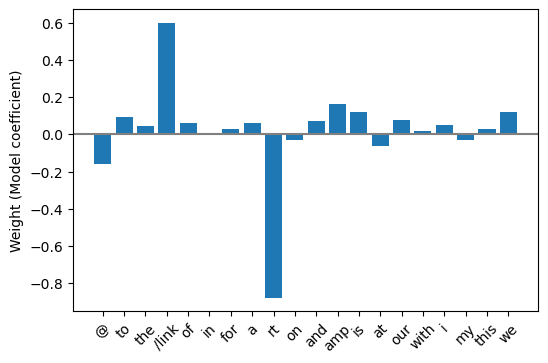

In [53]:
n = 20
w = model.coef_[:n]
plt.bar(range(n), w)
plt.axhline(0, color='gray')
plt.ylabel("Weight (Model coefficient)")
token_labels = [index_token_map[i] for i in range(n)]
plt.xticks(range(n), token_labels, rotation=45)

plt.show()

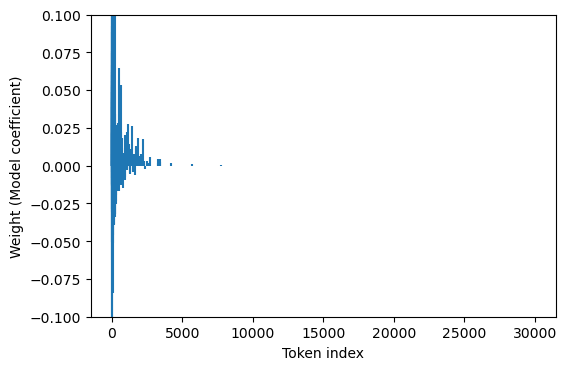

98.36% of the model coefficients are zero!


In [54]:
w = model.coef_
plt.vlines(range(len(w)), np.minimum(w, 0), np.maximum(w, 0))
plt.xlabel("Token index")
plt.ylabel("Weight (Model coefficient)")
plt.ylim(-0.1, 0.1)
plt.show()
print(f"{np.sum(w == 0) / len(w):.2%} of the model coefficients are zero!")

## TF-IDF: Improving our vector representations

To solve the problems we observe above, we can improve the quality of our vector representations.  [**TF-IDF**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is a re-weighting of the bag-of-words vectors we've constructed for each document that has strong empirical performance. The reweighting consists of two parts:

 - _Term frequency_ (TF): The term frequency is just the number of times the token appears in a document, which is what we are currently using.  We can improve our term frequency representation by taking the log of the raw count plus 1: this transformation serves to reduce the weight of a word occurring multiple times. Intuitively, a tweet that uses the same word twice should not use 
 - _Inverse Document Frequency_ (IDF): 

In [56]:
token_frequencies = np.zeros(V)
for index in range(V):
    token = index_token_map[index]
    token_frequencies[index] = token_counter[token]
assert np.all(token_frequencies > 0)

In [57]:
X = X / token_frequencies  # .reshape((1, -1))
X.shape

(200000, 30000)

In [60]:
model = sklearn.linear_model.Ridge(alpha=0.1, l1_ratio=0.01)
model.fit(X_train, y_train)
mean_squared_error, absolute_errors, y_pred = evaluate_model(model, X_test, y_test)
mean_squared_error

MemoryError: Unable to allocate 11.2 GiB for an array with shape (100000, 30000) and data type float32

In [ ]:
w = model.coef_
plt.vlines(range(len(w)), np.minimum(w, 0), np.maximum(w, 0))
plt.xlabel("Token index")
plt.ylabel("Weight (Model coefficient)")
plt.ylim(-0.1, 0.1)
plt.show()
print(f"{np.sum(w == 0) / len(w):.2%} of the model coefficients are zero!")

In [94]:
import sklearn.linear_model
model = sklearn.linear_model.ElasticNet(fit_intercept=False)
model.fit(X_train, y_train)
model.coef_.shape

(30001,)

In [95]:
# non-zero coefficients
np.sum(~np.isclose(model.coef_[:-1], 0))

907

In [113]:
w = model.coef_
weights = []
for i, weight in enumerate(w[:-1]):
    token = index_token_map[i]
    if weight != 0:
        weights.append({
            'token': token,
            'token_count': token_counter[token],
            'weight': weight,
            'abs_weight': np.abs(weight),
        })
        
#w = w[:-1]  # remove the intercept
#w.sort()
#w = w[~np.isclose(w, 0)]
weight_df = pd.DataFrame(weights)
len(weight_df)

907

In [114]:
weight_df.sort_values(by='weight', ascending=False).head(10)

,token,token_count,weight,abs_weight
2,the,735312,53.594498,53.594498
11,is,167350,51.791077,51.791077
9,and,250558,49.726624,49.726624
23,will,83496,43.519436,43.519436
18,we,118824,31.727180,31.727180
3,/link,499420,30.795961,30.795961
15,i,131962,30.680773,30.680773
6,a,279474,29.631046,29.631046
74,they,25131,24.120056,24.120056
31,have,63147,23.424078,23.424078


In [115]:
weight_df.sort_values(by='weight', ascending=True).head(10)

,token,token_count,weight,abs_weight
0,@,989015,-33.517887,33.517887
7,rt,267394,-31.069569,31.069569
20,today,103775,-10.088549,10.088549
42,thanks,44461,-6.418712,6.418712
37,bill,47668,-6.330957,6.330957
62,proud,29286,-4.065671,4.065671
38,house,47323,-3.883245,3.883245
21,from,88361,-3.640216,3.640216
51,act,35523,-3.527932,3.527932
93,office,21905,-3.497819,3.497819


In [118]:
weight_df[weight_df.token_count <= weight_df.token_count.quantile(0.99)].sort_values(by='abs_weight', ascending=True).head(10)

,token,token_count,weight,abs_weight
678,holdthefloor,613,0.001167,0.001167
418,visited,3838,-0.002096,0.002096
317,latest,6193,-0.003757,0.003757
461,ahead,2850,0.006283,0.006283
689,j,576,0.006338,0.006338
568,society,1473,0.006451,0.006451
895,g7,25,0.007846,0.007846
415,allow,3868,0.008158,0.008158
217,action,9263,-0.009150,0.009150
657,guy,800,0.010701,0.010701


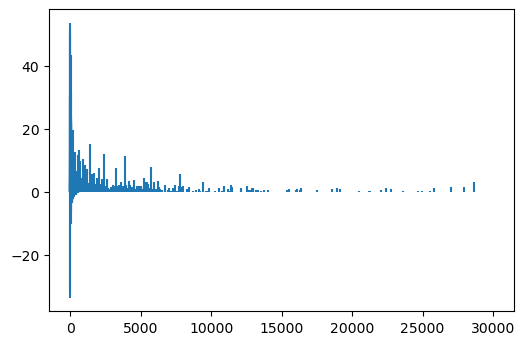

In [100]:
#random_inds = np.random.permutation(np.arange(len(w)))
w = model.coef_[:-1]
#plt.bar(range(len(w)), w, width=1)
plt.vlines(range(len(w)), np.minimum(w, 0), np.maximum(w, 0))
#plt.plot(range(len(w)), w, linewidth=1)
plt.show()

In [119]:
y_pred = model.predict(X_test)
y_pred.shape

(100000,)

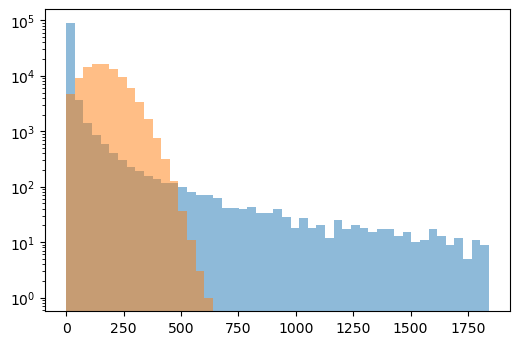

In [127]:
bins = np.linspace(0, np.quantile(y_test, 0.99))
plt.hist(y_test, bins=bins, alpha=0.5, log=True)
plt.hist(y_pred, bins=bins, alpha=0.5, log=True)
plt.show()

This is an indication that our model may not be expressive enough to capture more complex associations between tweet content and number of likes.

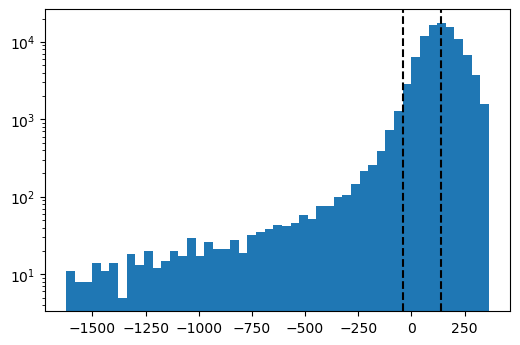

137.41283

In [142]:
errors = y_pred - y_test
plt.hist(errors, log=True, bins=np.linspace(np.quantile(errors, 0.01), np.quantile(errors, 0.99)))
plt.axvline(np.mean(errors), linestyle='--', color='black')
plt.axvline(np.median(errors), linestyle='--', color='black')
plt.show()
np.median(errors)

If we just use the mean or the median, we'd misunderstand our model's behavior.

 - More than half of tweets we overestimate the number of likes they'll receive.
 - ... but, we sometimes are horribly wrong (i.e. bad at predicting breakout successes).

In [136]:
np.sum(np.abs(errors) <= 100) / len(errors)

0.30653

In [138]:
np.sum(errors < 0) / len(errors)

0.08007